In [19]:
#!pip install lightgbm

In [20]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [21]:
def create_folder(folder_path):
    """
    Check whether the specified path exists or not
    Create a new directory if it does not exist 
    """
    isExist = os.path.exists(folder_path)
    if not isExist:
        os.makedirs(folder_path)
path = "./results/3_machine_learning/"

In [22]:
class Classifier:
    
    def __init__(self, name, clf, X_train, y_train, X_test, y_test):
        self.clf = clf
        self.name = name
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test        
    
    def run_classification(self):
        self.clf.fit(self.X_train, self.y_train)
        self.y_pred = self.clf.predict(self.X_test)
        self.report = pd.DataFrame(classification_report(self.y_test, self.y_pred, output_dict=True))
        self.cf_matrix = pd.DataFrame(confusion_matrix(self.y_test, self.y_pred))
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        print(self.cf_matrix)
        print(self.report)
        print("Accuracy: %.2f%%" % (self.accuracy * 100.0))
        self.results = {
            "classifier": self.name,
            "average precision": average_precision_score(self.y_test, self.y_pred),
            "precision": precision_score(self.y_test, self.y_pred),
            "recall": recall_score(self.y_test, self.y_pred),
            "accuracy": accuracy_score(self.y_test, self.y_pred),            
            "f1 score": f1_score(self.y_test, self.y_pred),
            "roc_auc": roc_auc_score(self.y_test, self.y_pred)
        }
        self.save_results()
    
    def save_results(self):
        folder_path = "./results/3_machine_learning/{}/{}/".format("testing_models", self.name)
        create_folder(folder_path)
        self.report = pd.DataFrame(classification_report(self.y_test, self.y_pred, output_dict=True))
        self.report.to_csv(folder_path + "classification_report.csv")
        self.cf_matrix.to_csv(folder_path + "cf_matrix.csv")
        sns_plot = sns.heatmap(self.cf_matrix/np.sum(self.cf_matrix), annot=True, fmt='.2%', cmap='Blues')
        fig = sns_plot.get_figure()
        fig.savefig("./results/3_machine_learning/{}/{}/_cf_matrix.png".format("testing_models", self.name))
        plt.clf()
        
        
models = {
    "KNC": KNeighborsClassifier(2),
    "GradBoost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    "LR": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "DT": DecisionTreeClassifier(),
    "NB": GaussianNB(),
    "SGD": SGDClassifier(loss="hinge", penalty="l2"),
    "LGBM": LGBMClassifier(max_depth=10, num_leaves=246, n_estimators=380, min_data_in_leaf=20),
    "SVM": LinearSVC(),
    "RF": RandomForestClassifier(bootstrap=True,
                class_weight="balanced_subsample", 
                criterion='gini',
                max_depth=8, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=4, min_samples_split=10,
                min_weight_fraction_leaf=0.0, n_estimators=300,
                oob_score=False,
                random_state=35,
                verbose=0, warm_start=False)
}
        

In [23]:
df = pd.read_csv("./results/0_data_cleaning/dataset.csv")
#df =  pd.read_csv("./train_dataset.csv")
grp = df.groupby("accident_severity")
df_serious = grp.get_group("Serious")
df_slight = grp.get_group("Slight")
df = pd.concat([df_serious.sample(20000), df_slight.sample(21000)])
df = df.drop(columns=["id"])

X = df.drop('accident_severity',axis=1)
y = df['accident_severity'].replace(['Fatal'], 'Serious')

y_encoded = LabelEncoder().fit_transform(y)
X_encoded = X.copy()
for col in X.columns:
    if X[col].dtype == np.dtype('O'):
        X_encoded[col] = LabelEncoder().fit_transform(X[col])
    if X[col].dtype == np.dtype('int64') or X[col].dtype == np.dtype('float64'):
        X_encoded[col] = StandardScaler().fit_transform(X[col].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded)

In [24]:
X.columns

Index(['year', 'month', 'hour', '1st_road_class', 'carriageway_hazards',
       'junction_control', 'day', 'junction_detail', 'light_conditions',
       'road_surface_conditions', 'road_type', 'special_conditions_at_site',
       'speed_limit', 'time', 'urban_or_rural_area', 'weather_conditions',
       'latitude', 'longitude', 'number_of_casualties', 'number_of_vehicles',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities'],
      dtype='object')

In [25]:
RF = Classifier("RF", models["RF"], X_train, y_train, X_test, y_test)
RF.run_classification()

      0     1
0  2456  1544
1  1611  2589
                     0            1  accuracy    macro avg  weighted avg
precision     0.603885     0.626421  0.615244     0.615153      0.615428
recall        0.614000     0.616429  0.615244     0.615214      0.615244
f1-score      0.608900     0.621385  0.615244     0.615143      0.615295
support    4000.000000  4200.000000  0.615244  8200.000000   8200.000000
Accuracy: 61.52%


<Figure size 432x288 with 0 Axes>

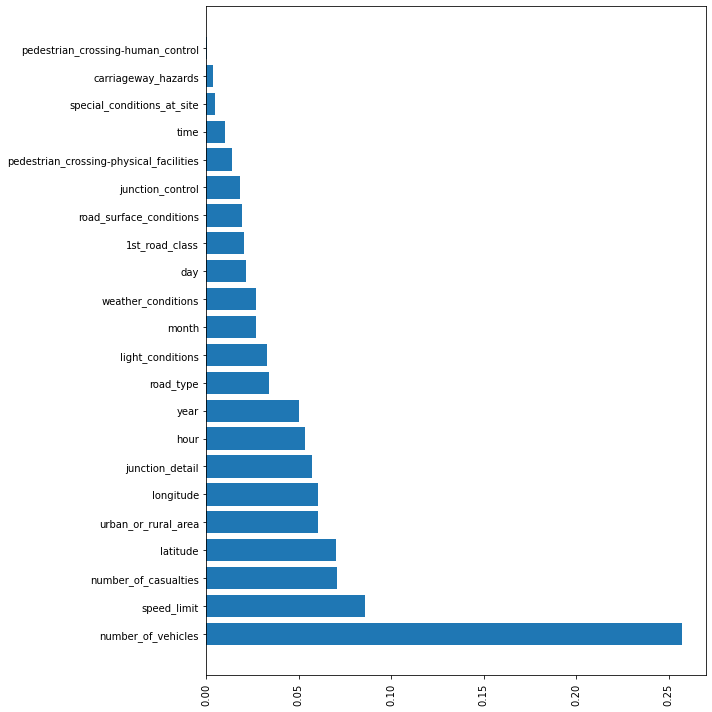

In [26]:
feature_importances = pd.DataFrame([{feature: importance for feature, importance in zip(X.columns, RF.clf.feature_importances_)}])
feature_importances = feature_importances.T.sort_values(by=0, ascending=False).rename(columns={0:"importance_value"})
feature_importances["importance_value"]

# Increase the width
plt.figure(figsize=(10,10))
plt.barh(feature_importances.index, feature_importances.importance_value)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(path + "RF_first_feature_importance.png")


#### It is clear that number of casualties and vehicles will give us information about the accident severity ultimately, however in practical cases where we want to actually predict the severity, such information would not be available and it would not make sense to you them as prediction factors, hence we drop them then train our model again.

In [27]:
df = pd.read_csv("./results/0_data_cleaning/dataset.csv")
grp = df.groupby("accident_severity")
df_serious = grp.get_group("Serious")
df_slight = grp.get_group("Slight")
df = pd.concat([df_serious.sample(20000), df_slight.sample(21000)])
df = df.drop(columns=["id", "number_of_casualties", "number_of_vehicles"])

X = df.drop('accident_severity',axis=1)
y = df['accident_severity'].replace(['Fatal'], 'Serious')

y_encoded = LabelEncoder().fit_transform(y)
X_encoded = X.copy()
for col in X.columns:
    if X[col].dtype == np.dtype('O'):
        X_encoded[col] = LabelEncoder().fit_transform(X[col])
    if X[col].dtype == np.dtype('int64') or X[col].dtype == np.dtype('float64'):
        X_encoded[col] = StandardScaler().fit_transform(X[col].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded)

In [28]:
RF = Classifier("RF", models["RF"], X_train, y_train, X_test, y_test)
RF.run_classification()

      0     1
0  2001  1999
1  1420  2780
                     0            1  accuracy    macro avg  weighted avg
precision     0.584917     0.581712  0.583049     0.583314      0.583275
recall        0.500250     0.661905  0.583049     0.581077      0.583049
f1-score      0.539280     0.619223  0.583049     0.579252      0.580226
support    4000.000000  4200.000000  0.583049  8200.000000   8200.000000
Accuracy: 58.30%


<Figure size 432x288 with 0 Axes>

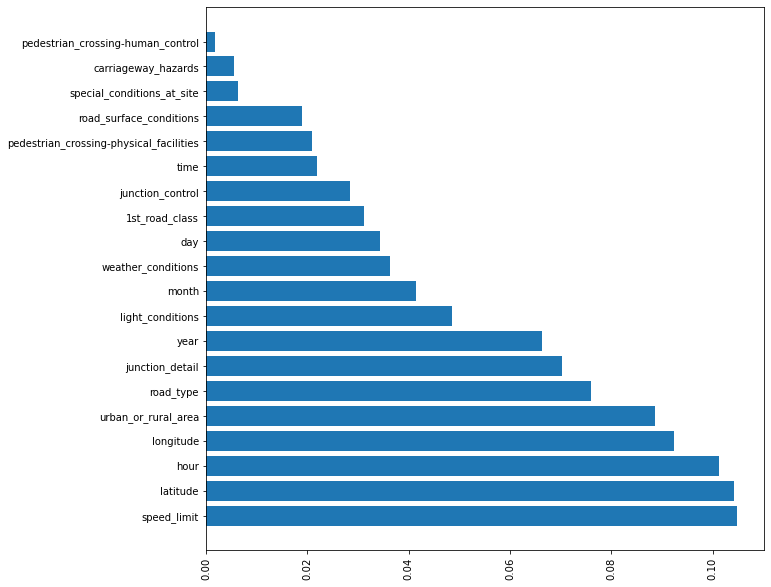

In [29]:
feature_importances = pd.DataFrame([{feature: importance for feature, importance in zip(X.columns, RF.clf.feature_importances_)}])
feature_importances = feature_importances.T.sort_values(by=0, ascending=False).rename(columns={0:"importance_value"})
feature_importances["importance_value"]

# Increase the width
plt.figure(figsize=(10,10))
plt.barh(feature_importances.index, feature_importances.importance_value)
plt.xticks(rotation=90)
plt.savefig(path + "RF_first_feature_importance.png")


In [30]:
feature_importances.index

Index(['speed_limit', 'latitude', 'hour', 'longitude', 'urban_or_rural_area',
       'road_type', 'junction_detail', 'year', 'light_conditions', 'month',
       'weather_conditions', 'day', '1st_road_class', 'junction_control',
       'time', 'pedestrian_crossing-physical_facilities',
       'road_surface_conditions', 'special_conditions_at_site',
       'carriageway_hazards', 'pedestrian_crossing-human_control'],
      dtype='object')

### Speed limit was shown to be the most contributing factor to the prediction of accident severity. Location factors such as the urban or rural area is also very important, in fact the feature "pedestrian human control" is not that relevant according as its importance value can be neglected compared to other areas. We will then drop carriageway hazards and special conditions at site for the same prior reason.  

In [31]:
df.columns

Index(['accident_severity', 'year', 'month', 'hour', '1st_road_class',
       'carriageway_hazards', 'junction_control', 'day', 'junction_detail',
       'light_conditions', 'road_surface_conditions', 'road_type',
       'special_conditions_at_site', 'speed_limit', 'time',
       'urban_or_rural_area', 'weather_conditions', 'latitude', 'longitude',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities'],
      dtype='object')

In [32]:
df = pd.read_csv("./results/0_data_cleaning/dataset.csv")
grp = df.groupby("accident_severity")
df_serious = grp.get_group("Serious")
df_slight = grp.get_group("Slight")
df = pd.concat([df_serious.sample(20000), df_slight.sample(21000)])
df = df.drop(columns=[
    "id", 
    "number_of_casualties", 
    "number_of_vehicles"
])

X = df.drop('accident_severity',axis=1)
y = df['accident_severity'].replace(['Fatal'], 'Serious')

y_encoded = LabelEncoder().fit_transform(y)
X_encoded = X.copy()
for col in X.columns:
    if X[col].dtype == np.dtype('O'):
        X_encoded[col] = LabelEncoder().fit_transform(X[col])
    if X[col].dtype == np.dtype('int64') or X[col].dtype == np.dtype('float64'):
        X_encoded[col] = StandardScaler().fit_transform(X[col].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded)

In [33]:
RF = Classifier("RF", models["RF"], X_train, y_train, X_test, y_test)
RF.run_classification()

      0     1
0  2006  1994
1  1383  2817
                     0            1  accuracy    macro avg  weighted avg
precision     0.591915     0.585533  0.588171     0.588724      0.588646
recall        0.501500     0.670714  0.588171     0.586107      0.588171
f1-score      0.542969     0.625236  0.588171     0.584103      0.585106
support    4000.000000  4200.000000  0.588171  8200.000000   8200.000000
Accuracy: 58.82%


<Figure size 432x288 with 0 Axes>

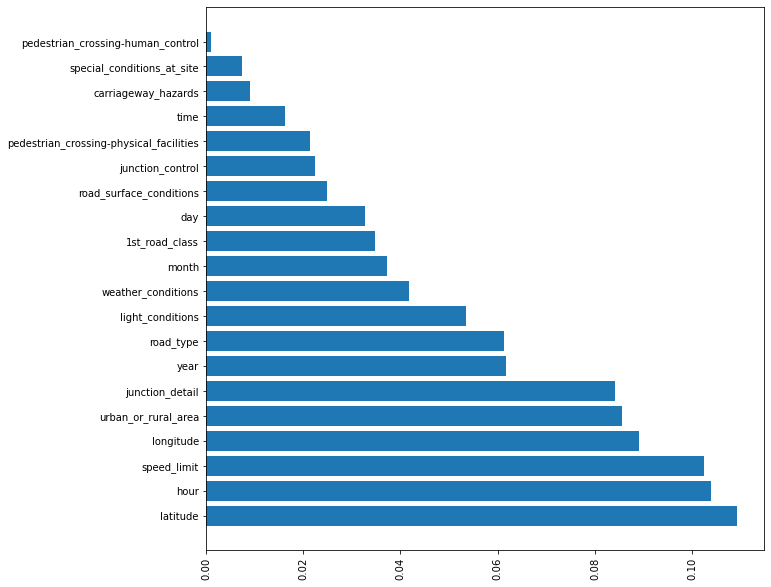

In [34]:
feature_importances = pd.DataFrame([{feature: importance for feature, importance in zip(X.columns, RF.clf.feature_importances_)}])
feature_importances = feature_importances.T.sort_values(by=0, ascending=False).rename(columns={0:"importance_value"})
feature_importances["importance_value"]

# Increase the width
plt.figure(figsize=(10,10))
plt.barh(feature_importances.index, feature_importances.importance_value)
plt.xticks(rotation=90)
plt.savefig(path + "RF_second_feature_importance.png")


In [35]:
df =  pd.read_csv("./results/0_data_cleaning/train_dataset.csv")

In [36]:
grp = df.groupby("accident_severity")
df_serious = grp.get_group("Serious")
df_slight = grp.get_group("Slight")
print(df_serious.shape, df_slight.shape)

(24693, 15) (45000, 15)


In [37]:
X = df.drop(['accident_severity'], axis=1)
y = df['accident_severity'].replace(['Fatal'], 'Serious')

In [38]:
y

0        Serious
1        Serious
2        Serious
3        Serious
4        Serious
          ...   
96057    Serious
96058    Serious
96059    Serious
96060    Serious
96061    Serious
Name: accident_severity, Length: 96062, dtype: object

In [39]:
y_encoded = LabelEncoder().fit_transform(y)
X_encoded = X.copy()
for col in X.columns:
    if X[col].dtype == np.dtype('O'):
        X_encoded[col] = LabelEncoder().fit_transform(X[col])
    if X[col].dtype == np.dtype('int64') or X[col].dtype == np.dtype('float64'):
        X_encoded[col] = StandardScaler().fit_transform(X[col].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded)

# Test of multiple algorithms

In [ ]:
fitted_classifiers = {}
results = []
for name, clf in models.items():
    clf = Classifier(name, clf, X_train, y_train, X_test, y_test)
    clf.run_classification()
    clf.save_results()
    results.append(clf.results)
    fitted_classifiers[name] = clf

df_results = pd.DataFrame(results)
df_results.to_csv(path + "ML_classifiers_comparison.csv") 
df_results

In [ ]:
RF = Classifier("RF", clf, X_train, y_train, X_test, y_test)

# Hyperparameter optimization

In [ ]:
RF = models["RF"]

def get_model():
    return RF

def get_hyperparams():
    return {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
from skopt import BayesSearchCV

search_parameters = {
    "cv": 3,
    "verbose": 0,
    "scoring": 'f1_macro',
    "n_iter": 20,
    "random_state": 42
}
bs = BayesSearchCV(get_model(), get_hyperparams(), **search_parameters)
bs.fit(X_train, y_train)

In [ ]:
print(bs.best_params_)
best = bs.best_estimator_
best.fit(X_train, y_train)
y_pred = best.predict(X_test)